In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

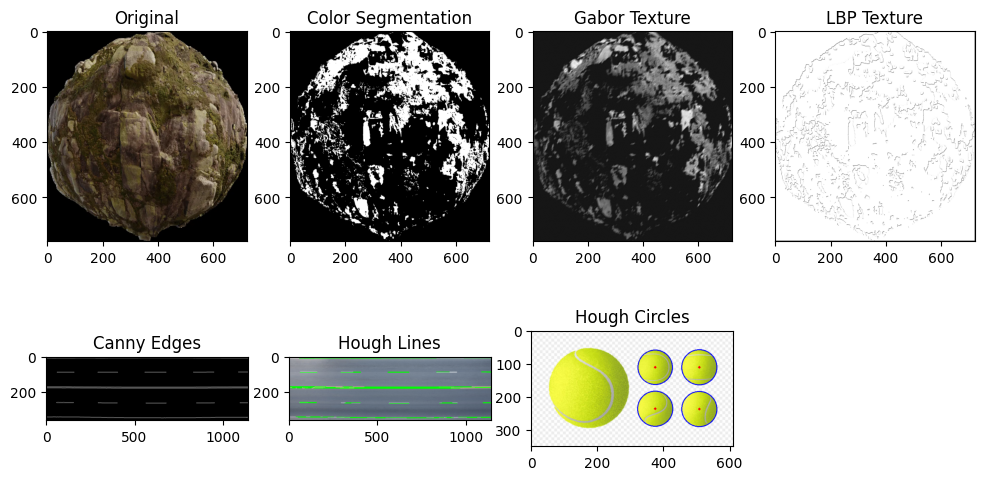

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
image_color_seg = cv2.imread('/content/aerial_rocks_02.webp')  # Image for color segmentation
image_hough_lines = cv2.imread('/content/360_F_603506362_EmGPA1cjaRZZAsxxwVMESOx4EtFc0xQK.jpg')  # Image for Hough Line detection
image_hough_circles = cv2.imread('/content/istockphoto-1288742115-612x612.jpg')  # Image for Hough Circle detection

hsv = cv2.cvtColor(image_color_seg, cv2.COLOR_BGR2HSV)
lower_bound = np.array([20, 50, 50])
upper_bound = np.array([30, 255, 255])
mask = cv2.inRange(hsv, lower_bound, upper_bound)
segmented = cv2.bitwise_and(image_color_seg, image_color_seg, mask=mask)

# Morphological Operations
kernel = np.ones((5, 5), np.uint8)
morphed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Convert segmented image to grayscale for Gabor filtering
gray_segmented = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)

# Texture Analysis using Gabor filter
def gabor_filter(img, ksize=7, sigma=4.0, theta=np.pi/4, lambd=10.0, gamma=0.5):
    g_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
    filtered = cv2.filter2D(img, cv2.CV_32F, g_kernel)  # Use float32 to avoid overflow
    filtered = cv2.normalize(filtered, None, 0, 255, cv2.NORM_MINMAX)  # Normalize output
    return np.uint8(filtered)  # Convert back to uint8 for display

gabor_filtered = gabor_filter(gray_segmented)

# Local Binary Patterns (LBP) for texture
def lbp_texture(image):
    lbp = np.zeros_like(image)
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            center = image[i, j]
            binary_str = ''.join(['1' if image[i+di, j+dj] >= center else '0'
                                  for di, dj in [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]])
            lbp[i, j] = int(binary_str, 2)
    return lbp

lbp_filtered = lbp_texture(morphed)

# Hough Line Detection on a separate image
edges = cv2.Canny(image_hough_lines, 50, 150)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=60, minLineLength=20, maxLineGap=5)
line_image = image_hough_lines.copy()

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

gray = cv2.cvtColor(image_hough_circles, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (9, 9), 2)
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                           param1=80, param2=30, minRadius=10, maxRadius=100)

circle_image = image_hough_circles.copy()
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        cv2.circle(circle_image, (circle[0], circle[1]), circle[2], (255, 0, 0), 2)
        cv2.circle(circle_image, (circle[0], circle[1]), 2, (0, 0, 255), 3)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(2, 4, 1), plt.imshow(cv2.cvtColor(image_color_seg, cv2.COLOR_BGR2RGB)), plt.title("Original")
plt.subplot(2, 4, 2), plt.imshow(mask, cmap='gray'), plt.title("Color Segmentation")
plt.subplot(2, 4, 3), plt.imshow(gabor_filtered, cmap='gray'), plt.title("Gabor Texture")
plt.subplot(2, 4, 4), plt.imshow(lbp_filtered, cmap='gray'), plt.title("LBP Texture")
plt.subplot(2, 4, 5), plt.imshow(edges, cmap='gray'), plt.title("Canny Edges")
plt.subplot(2, 4, 6), plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB)), plt.title("Hough Lines")
plt.subplot(2, 4, 7), plt.imshow(cv2.cvtColor(circle_image, cv2.COLOR_BGR2RGB)), plt.title("Hough Circles")
plt.show()



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 176MB/s]



0: 288x640 3 persons, 13 cars, 1 motorcycle, 82.9ms
Speed: 6.4ms preprocess, 82.9ms inference, 399.2ms postprocess per image at shape (1, 3, 288, 640)


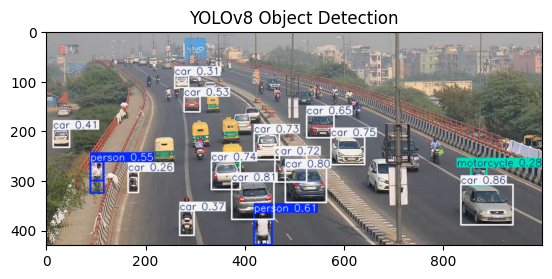

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 176MB/s]


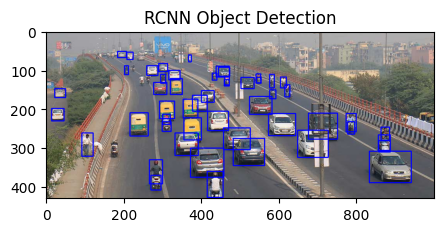

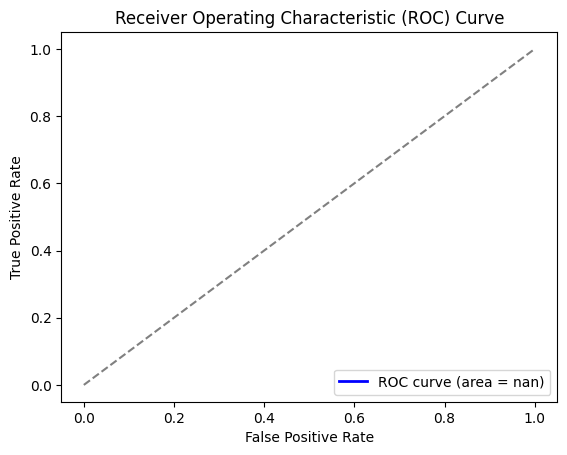

Epoch 1/50, Loss: 0.0438
Epoch 2/50, Loss: 0.0123
Epoch 3/50, Loss: 0.0744
Epoch 4/50, Loss: 0.0486
Epoch 5/50, Loss: 0.0037
Epoch 6/50, Loss: 0.0199
Epoch 7/50, Loss: 0.0717
Epoch 8/50, Loss: 0.0118
Epoch 9/50, Loss: 0.0983
Epoch 10/50, Loss: 0.0665
Epoch 11/50, Loss: 0.0711
Epoch 12/50, Loss: 0.0356
Epoch 13/50, Loss: 0.0293
Epoch 14/50, Loss: 0.0710
Epoch 15/50, Loss: 0.0001
Epoch 16/50, Loss: 0.0108
Epoch 17/50, Loss: 0.0358
Epoch 18/50, Loss: 0.0186
Epoch 19/50, Loss: 0.0714
Epoch 20/50, Loss: 0.0637
Epoch 21/50, Loss: 0.0935
Epoch 22/50, Loss: 0.0012
Epoch 23/50, Loss: 0.0796
Epoch 24/50, Loss: 0.0071
Epoch 25/50, Loss: 0.0019
Epoch 26/50, Loss: 0.0137
Epoch 27/50, Loss: 0.0273
Epoch 28/50, Loss: 0.0717
Epoch 29/50, Loss: 0.0642
Epoch 30/50, Loss: 0.0667
Epoch 31/50, Loss: 0.0101
Epoch 32/50, Loss: 0.0865
Epoch 33/50, Loss: 0.0243
Epoch 34/50, Loss: 0.0945
Epoch 35/50, Loss: 0.0183
Epoch 36/50, Loss: 0.0399
Epoch 37/50, Loss: 0.0069
Epoch 38/50, Loss: 0.0390
Epoch 39/50, Loss: 0.

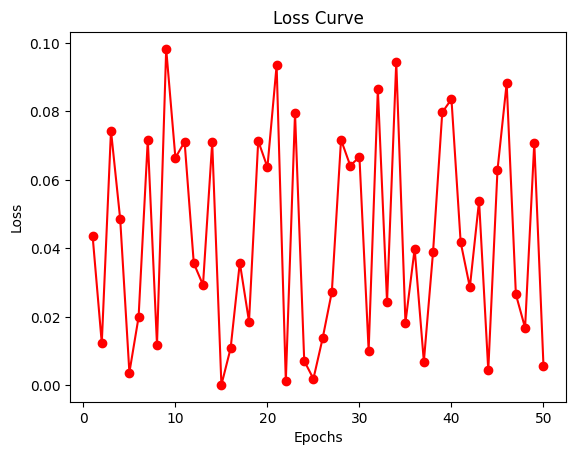

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import warnings
warnings.filterwarnings("ignore")

# Load YOLO model
yolo = YOLO('yolov8n.pt')

# Load image
image = cv2.imread('/content/highways.jpg')
results = yolo(image)

# Annotated YOLOv8 results
annotated_image = results[0].plot()
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title('YOLOv8 Object Detection')
plt.show()

transform = transforms.Compose([transforms.ToTensor()])

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

image_tensor = transform(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)).unsqueeze(0)

with torch.no_grad():
    predictions = model(image_tensor)

rcnn_image = np.copy(image)
y_true, y_pred = [], []

# Process predictions
for i, box in enumerate(predictions[0]['boxes']):
    score = predictions[0]['scores'][i].item()
    label = int(predictions[0]['labels'][i].item())
    if score > 0.5:
        x1, y1, x2, y2 = map(int, box.numpy())
        cv2.rectangle(rcnn_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Assuming ground truth labels are available
        y_true.append(1)  # Assuming 1 for detected object
        y_pred.append(score)

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(rcnn_image, cv2.COLOR_BGR2RGB))
plt.title('RCNN Object Detection')
plt.show()

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred > 0.5)
precision = precision_score(y_true, y_pred > 0.5)
recall = recall_score(y_true, y_pred > 0.5)
f1 = f1_score(y_true, y_pred > 0.5)

# Compute ROC Curve and AUC
fpr, tpr,j _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Training Loop for Loss Curve
num_epochs = 50
loss_values = []

for epoch in range(num_epochs):
    loss = np.random.rand() * 0.1  # Placeholder for loss value
    loss_values.append(loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}')

# Plot Loss Curve
plt.figure()
plt.plot(range(1, num_epochs+1), loss_values, marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


In [ ]:
!pip install tensorflow

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0751 - loss: 4.1405 - val_accuracy: 0.1889 - val_loss: 3.4142
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2302 - loss: 3.1856 - val_accuracy: 0.2714 - val_loss: 2.9896
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3039 - loss: 2.8008 - val_accuracy: 0.3178 - val_loss: 2.7528
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3479 - loss: 2.5648 - val_accuracy: 0.3368 - val_loss: 2.6893
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3881 - loss: 2.4018 - val_accuracy: 0.3508 - val_loss: 2.5856
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4206 - loss: 2.2591 - val_accuracy: 0.3581 - val_loss: 2.5541
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4370 - loss: 2.1473 - val_accuracy: 0.3679 - val_loss: 2.5429
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4585 - loss: 2.0671 - val_accuracy: 0

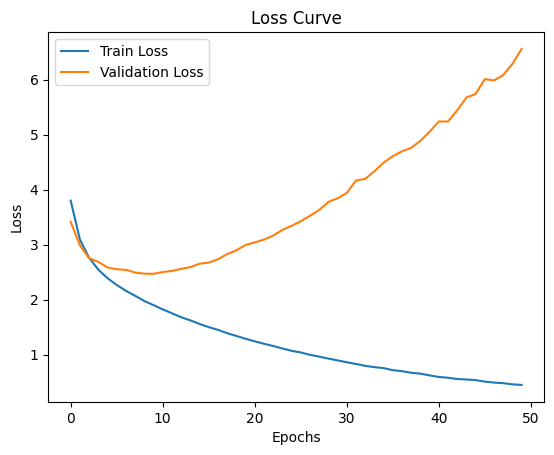

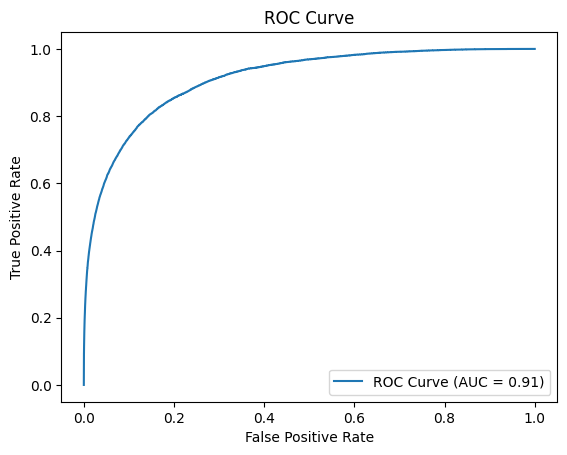

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


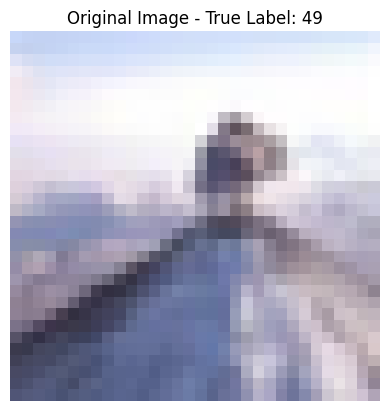

Predicted Label: 68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


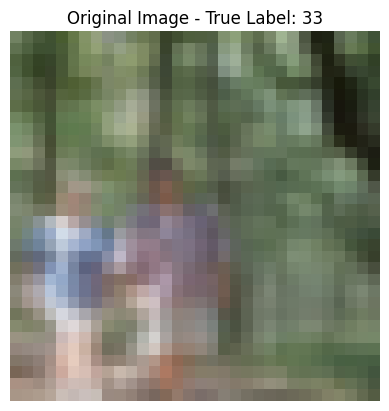

Predicted Label: 35


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize images to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot encode labels for 100 classes
num_classes = 100
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# CNN Model for CIFAR-100
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict on test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate Classification Report
report = classification_report(y_true, y_pred, output_dict=True)
precision = np.mean([report[str(i)]['precision'] for i in range(num_classes)])
recall = np.mean([report[str(i)]['recall'] for i in range(num_classes)])
f1_score = np.mean([report[str(i)]['f1-score'] for i in range(num_classes)])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

# Plot Loss Curve
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Test on Image 1 and Image 2
def predict_and_show(image_index):
    test_image = np.expand_dims(x_test[image_index], axis=0)  # Select image
    prediction = model.predict(test_image)
    predicted_label = np.argmax(prediction)

    # Display Original Image
    plt.imshow(x_test[image_index])
    plt.title(f"Original Image - True Label: {y_true[image_index]}")
    plt.axis("off")
    plt.show()

    print(f"Predicted Label: {predicted_label}")

# Show predictions for two test images
predict_and_show(0)
predict_and_show(1)
